# Segmentação em Processamento Digital de Imagens

Segunda parte sobre segmentação, sobre Transformada de Hough, Limiarização Global e Local e Segmentação de Regiões.

## Descrição

- **Transformada de Hough**

    A Transformada de Hough é uma técnica para detectar formas geométricas, como linhas e círculos, em uma imagem, mesmo na presença de ruído ou imperfeições. Ela converte o problema de detecção no espaço da imagem para o espaço de parâmetros, facilitando a identificação de padrões.

    - **Linhas**

        A Transformada de Hough funciona representando uma linha no espaço de parâmetros usando a equação:

        ```math
        r = x \cdot \cos(\theta) + y \cdot \sin(\theta)
        ```

        - Onde 𝑟 é a distância da linha à origem e 𝜃 é o ângulo de inclinação.
        - Cada pixel no espaço da imagem gera uma curva no espaço de parâmetros (𝑟,𝜃).
        - O ponto de interseção dessas curvas indica uma linha na imagem.

    - **Círculos**

        Transformada de Hough funciona baseando-se na equação de um círculo:

        ```math
        (x - a)^2 + (y - b)^2 = r^2
        ```

        - Onde (𝑎,𝑏) são as coordenadas do centro e 𝑟 é o raio.
        - Cada pixel da borda vota em possíveis centros (𝑎,𝑏) para diferentes valores de raio 𝑟.
        - Acúmulos no espaço paramétrico indicam a presença de círculos.
        - Possui mais parâmetros: 𝑎, 𝑏 e 𝑟.
        
- **Limiarização**

    - **Global**

        Define um único valor de limiar (𝑇) para segmentar a imagem em regiões claras e escuras.

    - **Otsu's**

        Calcula o limiar 𝑇 automaticamente, maximizando a separação entre as classes de pixels (claro e escuro). Funciona minimizando a variância intraclasse ou maximizando a variância interclasse.

    - **Adaptive Mean**

        Divide a imagem em pequenas regiões e calcula o limiar 𝑇 como a média dos valores de pixel em cada região.

        ```math
        T = \text{média local} - C
        ```

        - C: constante subtraída para ajuste do limiar.

    - **Adaptive Gaussian**

        Similar ao Adaptive Mean, mas o limiar 𝑇 é calculado como uma soma ponderada de valores de pixel, com pesos dados pela função Gaussiana. Melhor em imagens com transições suaves de iluminação.

        ```math
        T = \text{média ponderada local} - C
        ```

    - **Gaussian Blur + Otsu's**

        Aplica um borramento gaussiano (Gaussian Blur) para suavizar a imagem antes de usar o método de Otsu. Reduz ruídos e detalhes menores, tornando a distribuição de intensidades mais clara e melhorando o resultado em imagens com muito ruídos.

- **Segmentação de Regiões**

    - **K-means**

        É um algoritmo de agrupamento onde funciona dividindo os pixels em 𝐾 clusters baseados em características como cor, intensidade ou posição espacial. 
        
        Começa Definindo o número de clusters 𝐾 e inicializa-se 𝐾 centróides aleatórios

        **->** cada pixel é atribuído ao cluster cujo centróide está mais próximo, com base na distância Euclidiana

        **->** os centróides são recalculados como a média de pixels atribuídos a cada cluster

        **->** os passos são repetidos até que um critério de parada seja alcançado

        **->** os pixels da imagem são rotulados de acordo com seu cluster
    
        #### Em imagens:

        - **Segmentação de cores:** Agrupa pixels com cores semelhantes, útil para simplificar a imagem ou identificar objetos.
        - **Redução de cores:** Reduz o número de cores em uma imagem, comprimindo os dados sem perder muita qualidade.
        - **Identificação de regiões:** Detecta regiões de interesse baseadas em intensidade ou outras características.

        É simples e eficiente para segmentação básica, melhor desempenho em imagens com distinções claras entre regiões, porém é Sensível à inicialização dos centróides, à presença de ruído e baixa capacidade de diferenciar regiões com características muito semelhantes.




## Código

## Descrição

- **Transformada de Hough**

    - **Linhas**

        Detecta linhas usando a Transformada de Hough padrão:

        ```python
        def linhasPadrao(imagem, limiar=50, limiar2=200):
            imagem = np.array(imagem)
            imagem = cv2.GaussianBlur(imagem, (5, 5), 0)
            imagem = cv2.Canny(imagem, limiar, limiar2, apertureSize=3)
            
            linhas = cv2.HoughLines(imagem, 1, np.pi/180, 150, None, 0, 0)

            imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)

            if linhas is not None:
                for i in range(0, len(linhas)):
                    rho = linhas[i][0][0]
                    theta = linhas[i][0][1]
                    a = math.cos(theta)
                    b = math.sin(theta)
                    x0 = a * rho
                    y0 = b * rho
                    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
                    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
                    cv2.line(imagem, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)  

                return imagem
        ```

        Detecta linhas usando a Transformada de Hough probabilística:

        ```python
            
        def linhasProb(imagem, limiar=50, limiar2=200):
            imagem = np.array(imagem)
            imagem = cv2.GaussianBlur(imagem, (5, 5), 0)
            imagem = cv2.Canny(imagem, limiar, limiar2, apertureSize=3)

            linhas = cv2.HoughLinesP(imagem, 1, np.pi / 180, 50, 100, minLineLength=10, maxLineGap=250)

            imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)

            if linhas is not None:
            for i in range(0, len(linhas)):
                l = linhas[i][0]
                cv2.line(imagem, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)  
            
            return imagem
        ```


    - **Círculos**

        Detecta círculos utilizando a Transformada de Hough para gradientes:

        ```python
        def circulos(imagem, minDist=50, param1=30, param2=50, minRadius=0, maxRadius=0, blur=7):
            imagem = imagem.convert('L')
            imagem = np.array(imagem)
            white = np.full(imagem.shape, 255)
            blur = cv2.GaussianBlur(imagem, (blur, blur), 0)
            plot(imagem, blur, "Original", "Blur")
            circulos = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

            if circulos is not None:
                circulos = np.uint16(np.around(circulos))
                for i in circulos[0, :]:
                    cv2.circle(white, (i[0], i[1]), i[2], (0, 255, 0), 2)
                    cv2.circle(white, (i[0], i[1]), 2, (0, 0, 255), 3)

            return white
        ```
        
- **Limiarização**

    realiza a limiarização em cinco formas diferentes dependendo do parâmetro tipo:

    - **Global**:

        Um limiar fixo (127) é usado para todos os pixels da imagem.
        Se o valor do pixel for maior ou igual a 127, ele é definido como 255 (branco). Caso contrário, é definido como 0 (preto).

    - **Otsu**:

        Um método automático que calcula um limiar ideal com base na separação máxima entre as classes de intensidade de pixels.
        Útil para imagens bimodais (com dois picos bem definidos no histograma).

    - **Adaptive Mean**:

        A limiarização é aplicada localmente em pequenos blocos da imagem.
        O limiar é a média das intensidades dos vizinhos subtraída por um valor constante.

    - **Adaptive Gaussian**:

        Semelhante ao método anterior, mas o limiar é calculado com base em uma média ponderada usando uma janela gaussiana.

    - **Blur**:

        Primeiro, um desfoque gaussiano é aplicado para suavizar a imagem.
        Depois, é usado o método de Otsu para determinar o limiar ideal.

    ```python
    def threshold(imagem, tipo):
        imagem = imagem.convert('L')
        imagem = np.array(imagem)
        copia = imagem.copy()

        match tipo:
            case 'global':
                limiar = 127
                for i in range(copia.shape[0]):
                    for j in range(copia.shape[1]):
                        if copia[i][j] >= limiar:
                            copia[i][j] = 255
                        else:
                            copia[i][j] = 0
            case 'otsu':
                limiar = cv2.threshold(copia, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                copia = limiar
            case 'adaptiveMean':
                copia = cv2.adaptiveThreshold(copia, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
            case 'adaptiveGaussian':
                copia = cv2.adaptiveThreshold(copia, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            case 'blur':
                copia = cv2.GaussianBlur(copia, (5, 5), 0)
                copia = cv2.threshold(copia, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        
        return copia
    ```

- **Segmentação de Regiões**

    - **K-means**

        - A imagem é convertida para um array NumPy para facilitar o processamento.
        - É "achatada" para transformar os pixels em uma matriz bidimensional (𝑁 × 3), onde cada linha representa um pixel com valores RGB.
        - O algoritmo para após 100 iterações ou quando a mudança entre os centroides cai abaixo de 0.2.
        - O OpenCV realiza a clusterização
        - A primeira imagem resultante é criada substituindo os pixels originais pelas cores do centroide correspondente.
        - A segunda imagem resultante é criada mapeando os clusters para cores predefinidas em cores.

        ```python
        def kmeans(imagem, k=8):
            imagem = np.array(imagem)
            copia = imagem.copy()
            
            Z = np.float32(imagem.reshape((-1,3)))

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
            
            ret,label,center=cv2.kmeans(Z,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

            center = np.uint8(center)
            res = center[label.flatten()]
            res2 = res.reshape((imagem.shape))

            cores = np.array((
                [0, 0, 255],
                [0, 255, 0],
                [255, 0, 0],
                [0, 255, 255],
                [255, 0, 255],
                [255, 255, 0],
                [0, 0, 0],
                [255, 255, 255]
            )
            , dtype=float)

            res = cores[label.flatten()]
            res3 = res.reshape((imagem.shape))

            return res2, res3
        ```

### Código Transformada de Hough

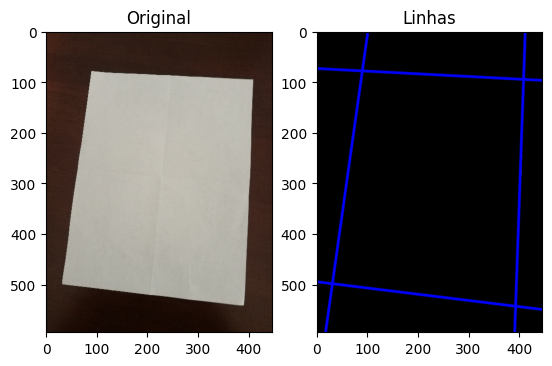

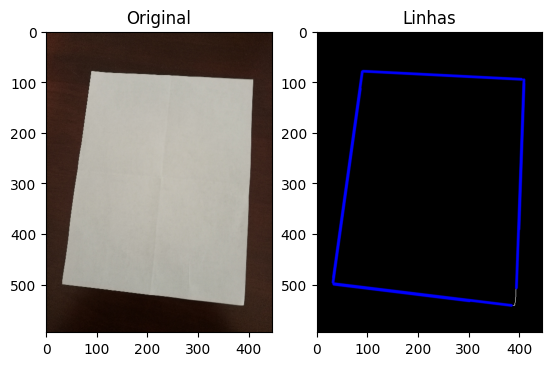

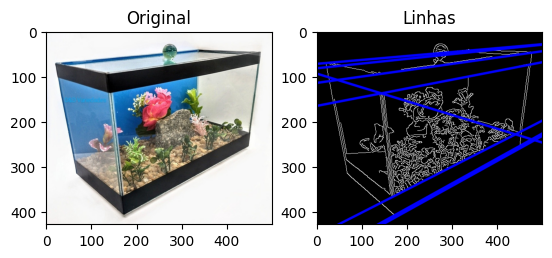

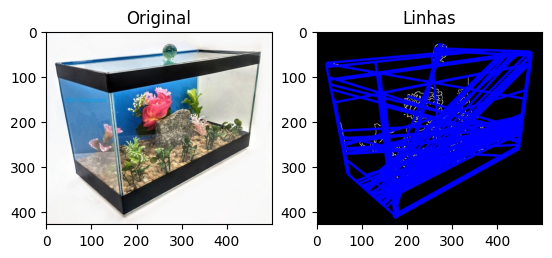

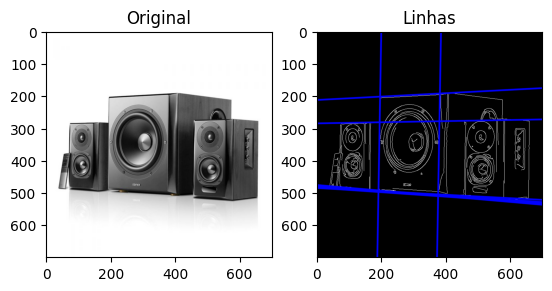

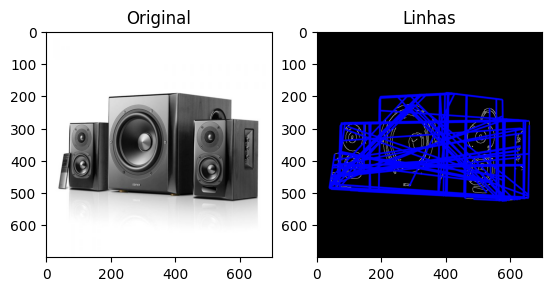

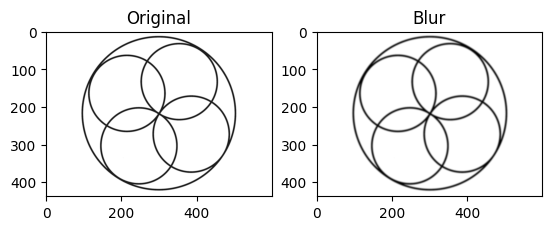

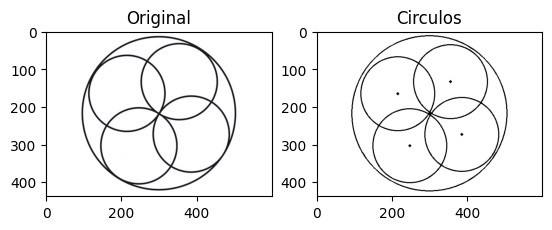

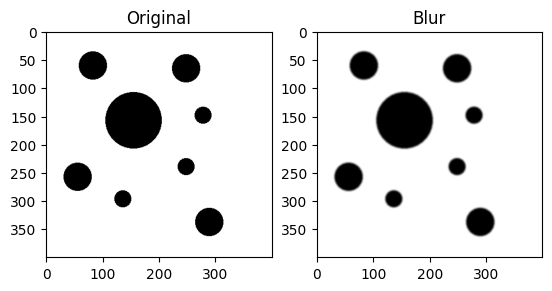

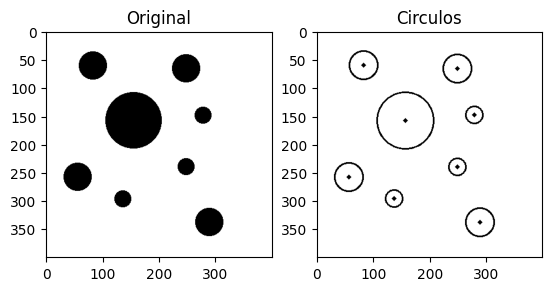

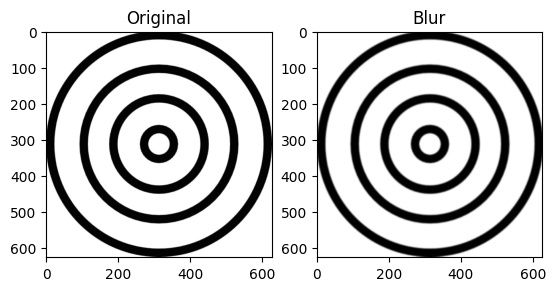

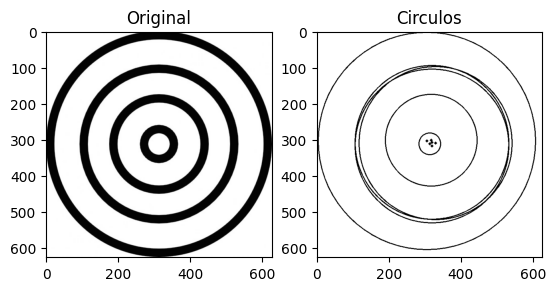

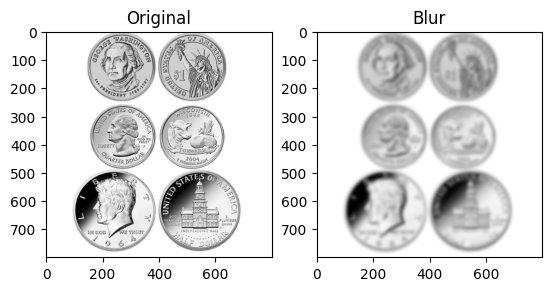

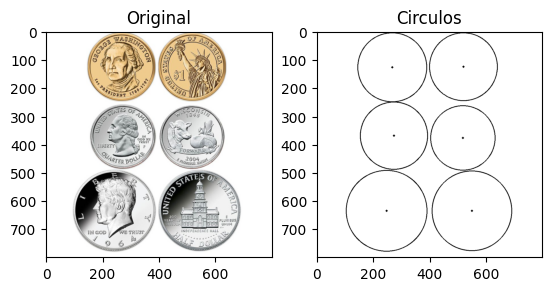

In [2]:
import datetime
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import math

def plot(img, edit, txt1, txt2):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(txt1)
    ax[1].imshow(edit, cmap='gray')
    ax[1].set_title(txt2)
    plt.show()

def salvar(imagem, nome):
    print("Desenha salvar a imagem? (s/N)")
    entrada = input()
    if entrada == "s":
        time = datetime.datetime.now().strftime("%Y-%m-%d")
        imagem.save(f'imgs/{nome}{time}.png')

def convolucao(imagem, kernel):
    return scipy.signal.convolve2d(imagem, kernel, mode='same')

def threshold(imagem, limiar):
    copia = imagem.copy()
    # 1 𝑠𝑒 | 𝑅 𝑥, 𝑦 ≥ 𝑇
    # 0 𝑐𝑎𝑠𝑜 𝑜 𝑐𝑜𝑛𝑡𝑟á𝑟𝑖o
    for i in range(copia.shape[0]):
        for j in range(copia.shape[1]):
            if copia[i][j] >= limiar:
                copia[i][j] = 1
            else:
                copia[i][j] = 0
    return copia

def limiarizacao(imagem, limiar):
    copia = imagem.copy()
    for i in range(copia.shape[0]):
        for j in range(copia.shape[1]):
            if copia[i][j] >= limiar:
                copia[i][j] = 255
            else:
                copia[i][j] = 0
    return copia

def linhasPadrao(imagem, limiar=50, limiar2=200):
    imagem = np.array(imagem)
    imagem = cv2.GaussianBlur(imagem, (5, 5), 0)
    imagem = cv2.Canny(imagem, limiar, limiar2, apertureSize=3)
    
    linhas = cv2.HoughLines(imagem, 1, np.pi/180, 150, None, 0, 0)

    imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)

    if linhas is not None:
        for i in range(0, len(linhas)):
            rho = linhas[i][0][0]
            theta = linhas[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(imagem, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)  

        return imagem
    
def linhasProb(imagem, limiar=50, limiar2=200):
    imagem = np.array(imagem)
    imagem = cv2.GaussianBlur(imagem, (5, 5), 0)
    imagem = cv2.Canny(imagem, limiar, limiar2, apertureSize=3)

    linhas = cv2.HoughLinesP(imagem, 1, np.pi / 180, 50, 100, minLineLength=10, maxLineGap=250)

    imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)

    if linhas is not None:
      for i in range(0, len(linhas)):
          l = linhas[i][0]
          cv2.line(imagem, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)  
    
    return imagem

def circulos(imagem, minDist=50, param1=30, param2=50, minRadius=0, maxRadius=0, blur=7):
    imagem = imagem.convert('L')
    imagem = np.array(imagem)
    white = np.full(imagem.shape, 255)
    blur = cv2.GaussianBlur(imagem, (blur, blur), 0)
    plot(imagem, blur, "Original", "Blur")
    circulos = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

    if circulos is not None:
        circulos = np.uint16(np.around(circulos))
        for i in circulos[0, :]:
            cv2.circle(white, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(white, (i[0], i[1]), 2, (0, 0, 255), 3)

    return white

def main():
    papel = Image.open('imgs/paper.png')
    aqua = Image.open('imgs/aqua.jpg')
    som = Image.open('imgs/som.jpg')
    circulo1 = Image.open('imgs/circles.jpg')
    circulo2 = Image.open('imgs/circles.png')
    circulo3 = Image.open('imgs/circles2.jpg')
    moedas = Image.open('imgs/coins.jpg')



    plot(papel, linhasPadrao(papel), "Original", "Linhas")
    plot(papel, linhasProb(papel), "Original", "Linhas")

    plot(aqua, linhasPadrao(aqua), "Original", "Linhas")
    plot(aqua, linhasProb(aqua), "Original", "Linhas")

    plot(som, linhasPadrao(som), "Original", "Linhas")
    plot(som, linhasProb(som), "Original", "Linhas")
    
    #---------------------------------------------------------------------------------- #

    plot(circulo1, circulos(circulo1), "Original", "Circulos")
    plot(circulo2, circulos(circulo2), "Original", "Circulos")
    plot(circulo3, circulos(circulo3, minDist=0.001, param1=695, param2=138.5, minRadius=0, maxRadius=0), "Original", "Circulos")
    plot(moedas, circulos(moedas, minDist=100, param1=30, param2=80, minRadius=0, maxRadius=0, blur=35), "Original", "Circulos")

    #---------------------------------------------------------------------------------- #

    

if __name__ == "__main__":
    main()


### Código Limiarização

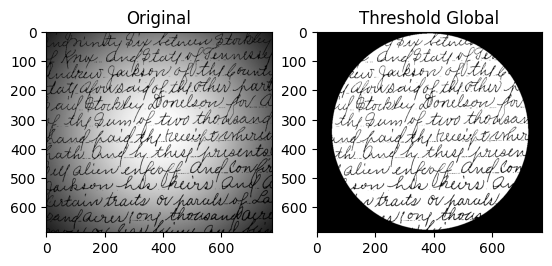

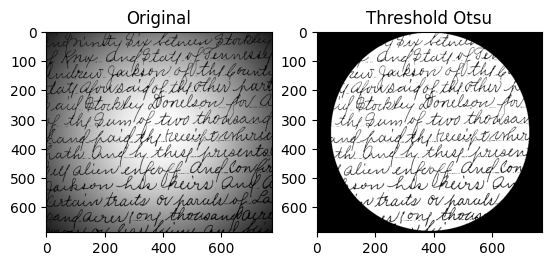

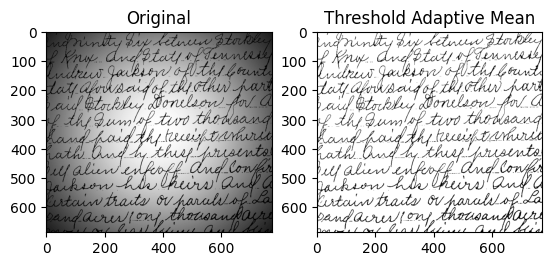

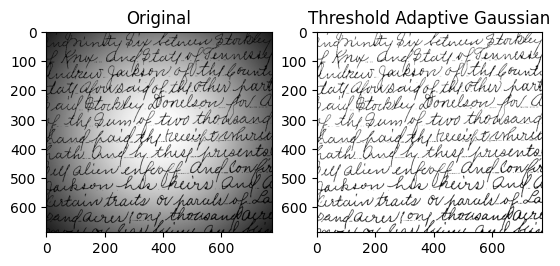

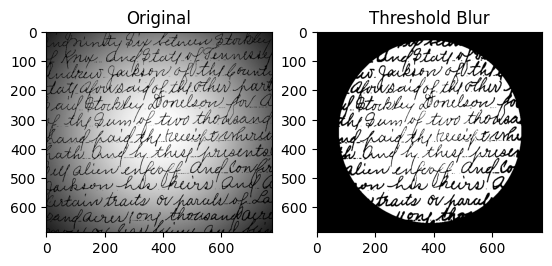

In [4]:
import datetime
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import math

def plot(img, edit, txt1, txt2):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(txt1)
    ax[1].imshow(edit, cmap='gray')
    ax[1].set_title(txt2)
    plt.show()

def salvar(imagem, nome):
    print("Desenha salvar a imagem? (s/N)")
    entrada = input()
    if entrada == "s":
        time = datetime.datetime.now().strftime("%Y-%m-%d")
        imagem.save(f'imgs/{nome}{time}.png')

def threshold(imagem, tipo):
    imagem = imagem.convert('L')
    imagem = np.array(imagem)
    copia = imagem.copy()

    match tipo:
        case 'global':
            limiar = 127
            for i in range(copia.shape[0]):
                for j in range(copia.shape[1]):
                    if copia[i][j] >= limiar:
                        copia[i][j] = 255
                    else:
                        copia[i][j] = 0
        case 'otsu':
            limiar = cv2.threshold(copia, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            copia = limiar
        case 'adaptiveMean':
            copia = cv2.adaptiveThreshold(copia, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        case 'adaptiveGaussian':
            copia = cv2.adaptiveThreshold(copia, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        case 'blur':
            copia = cv2.GaussianBlur(copia, (5, 5), 0)
            copia = cv2.threshold(copia, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    return copia

def main():
    text = Image.open('imgs/hand_text.tif')

    plot(text, threshold(text, 'global'), 'Original', 'Threshold Global')
    plot(text, threshold(text, 'otsu'), 'Original', 'Threshold Otsu')
    plot(text, threshold(text, 'adaptiveMean'), 'Original', 'Threshold Adaptive Mean')
    plot(text, threshold(text, 'adaptiveGaussian'), 'Original', 'Threshold Adaptive Gaussian')
    plot(text, threshold(text, 'blur'), 'Original', 'Threshold Blur')

if __name__ == "__main__":
    main()


### Código Segmentação de Regiões

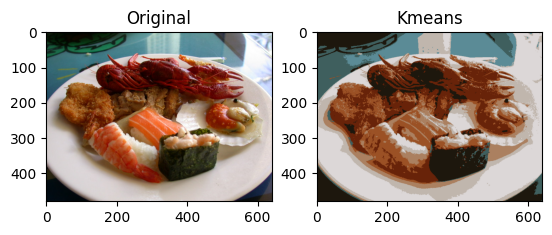

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


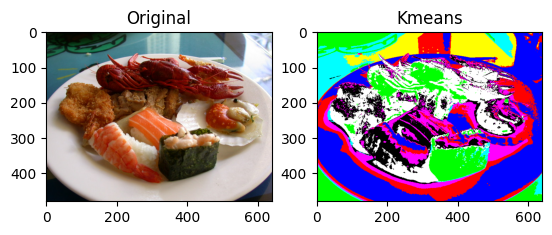

In [5]:
import datetime
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import math

def plot(img, edit, txt1, txt2):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(txt1)
    ax[1].imshow(edit, cmap='gray')
    ax[1].set_title(txt2)
    plt.show()

def salvar(imagem, nome):
    print("Desenha salvar a imagem? (s/N)")
    entrada = input()
    if entrada == "s":
        time = datetime.datetime.now().strftime("%Y-%m-%d")
        imagem.save(f'imgs/{nome}{time}.png')

def kmeans(imagem, k=8):
    imagem = np.array(imagem)
    copia = imagem.copy()
    
    Z = np.float32(imagem.reshape((-1,3)))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    ret,label,center=cv2.kmeans(Z,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((imagem.shape))

    cores = np.array((
        [0, 0, 255],
        [0, 255, 0],
        [255, 0, 0],
        [0, 255, 255],
        [255, 0, 255],
        [255, 255, 0],
        [0, 0, 0],
        [255, 255, 255]
    )
    , dtype=float)

    res = cores[label.flatten()]
    res3 = res.reshape((imagem.shape))

    return res2, res3


def main():
    sushi = Image.open('imgs/sushi.jpg')

    a, b = kmeans(sushi, 8)
    plot(sushi, a, "Original", "Kmeans")
    plot(sushi, b, "Original", "Kmeans")

if __name__ == "__main__":
    main()
